# Capstone: Development of an algorithm for automatic detection of meniscus tears in radiographic images of the knee.

### Contents:
- [Background](#Background)
- [Data](#Data)
- [Building own models](#Building-own-models)
- [Evaluate results](#Evaluate-results)



In [1]:
# Import libraries here
import os
import tempfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob

import nibabel as nib
from intensity_normalization.normalize.fcm import FCMNormalize
from intensity_normalization.plot.histogram import HistogramPlotter, plot_histogram

import random as random
import imageio
import imgaug as ia
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import save_img, load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Average, Input, Activation, Reshape, TimeDistributed
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import utils
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from tensorflow.keras.utils import plot_model
pd.options.mode.chained_assignment = None  # default='warn'

tmpdir = tempfile.mkdtemp()


**Data from [MRNet](https://stanfordmlgroup.github.io/competitions/mrnet/):** 
* Images of 1370 knee MRI exams performed at Stanford University Medical Center. The dataset contains 1,104 (80.6%) abnormal exams,  with 319 (23.3%) ACL tears and 508 (37.1%) meniscal tears; labels were obtained through manual extraction from clinical reports. 
* train set: consists of 1130 MRI images from coronal, sagittal and transverse planes
* valdation set: consists of 120 MRI images from coronal, sagittal and transverse planes


## Data import

**import data and get labels**

In [2]:
train_path = '../data/train/'
valid_path = '../data/valid/'

In [3]:
datasets = {'train': train_path, 'valid': valid_path}
planes = ['axial', 'coronal', 'sagittal']
# diagnosis = ['abnormal','meniscus','acl']

In [4]:
def get_data(dataset_type, plane, diagnosis):
    # for eg, (train, sagittal, acl)
    if dataset_type == 'train':
        go = train_path
    else:
        go = valid_path
        
#     img_path = glob(f'{go}/{plane}/*.npy')
    plane_dir = f'{go}/{plane}'
    data = os.listdir(plane_dir)
    
    label_path = f'../data/{dataset_type}-{diagnosis}.csv'
#     label_path = f'data/{dataset_type}-{diagnosis}.csv'
    label_df = pd.read_csv(label_path, names=['nr', diagnosis])
    label_data = list(label_df[diagnosis])
    
    return(data, plane_dir, label_data)

**meniscus dataset**

In [5]:
# training data
train_coronal_data, train_coronal_dir, train_men_label = get_data('train', 'coronal', 'meniscus')
train_axial_data, train_axial_dir, train_men_label = get_data('train', 'axial', 'meniscus')
train_sagittal_data, train_sagittal_dir, train_men_label = get_data('train', 'sagittal', 'meniscus')

In [6]:
# validation data
valid_coronal_data, valid_coronal_dir, valid_men_label = get_data('valid','coronal','meniscus')
valid_axial_data, valid_axial_dir, valid_men_label = get_data('valid','axial','meniscus')
valid_sagittal_data, valid_sagittal_dir, valid_men_label = get_data('valid','sagittal','meniscus')

In [7]:
train_coronal_data[0]

'0000.npy'

In [8]:
train_coronal_dir

'../data/train//coronal'

The dataset contains *s* x 256 x 256 images. Since middle images are the most useful, only 3 middle slides in the series are retained. 


In [9]:
def image_extraction(data, path, new_path): #3 images
    '''this function extracts middle 3 slides of each scan'''
    extract=[]
    new_data=[]
    for i in range(len(data)): 
        img = np.load(os.path.join(path,data[i]))
        middle_idx = int(img.shape[0]/2)
#         print(img.shape[0],middle_idx)
        img = img[(middle_idx - 1) : (middle_idx + 2)]
#         # reshape adapted for model (s x 256 x 256 x 1)
#         img_reshape = np.repeat(img[..., np.newaxis], 1, -1)
        img = img.reshape(256,256,3)
        extract.extend(img)
        new_data.append(np.array(extract))        
        extract.clear()
        
#     new_data.shape(1130,256,256,3) for train
#     new_data.shape(120,256,256,3) for valid
    np.save(new_path, np.array(new_data))


**image extraction for training data**

In [10]:
# image extraction for 3 planes
new_path = '../data/train_transform/coronal'
image_extraction(train_coronal_data, train_coronal_dir, new_path)

In [11]:
new_path = '../data/train_transform/axial'
image_extraction(train_axial_data, train_axial_dir, new_path)

In [12]:
new_path = '../data/train_transform/sagittal'
image_extraction(train_sagittal_data, train_sagittal_dir, new_path)

In [13]:
image = np.load('../data/train_transform/sagittal.npy')

In [14]:
image[0].shape

(256, 256, 3)

**extraction for validation data**

In [15]:
# image extraction for 3 planes
new_path = '../data/valid_transform/coronal'
image_extraction(valid_coronal_data, valid_coronal_dir, new_path)

In [16]:
new_path = '../data/valid_transform/axial'
image_extraction(valid_axial_data, valid_axial_dir, new_path)

In [17]:
new_path = '../data/valid_transform/sagittal'
image_extraction(valid_sagittal_data, valid_sagittal_dir, new_path)

In [18]:
image = np.load('../data/valid_transform/sagittal.npy')
image.shape

(120, 256, 256, 3)

**data generation for meniscus**

In [19]:
def data_gen(dataset_type, plane, diagnosis):
    # for eg, (train, sagittal, mensicus)
    if dataset_type == 'train':
        go = '../data/train_transform/'
    else:
        go = '../data/valid_transform/'
        
    plane_dir = f'{go}/{plane}.npy'
    
    data = np.load(plane_dir)
    label_path = f'../data/{dataset_type}-{diagnosis}.csv'
#     label_path = f'data/{dataset_type}-{diagnosis}.csv'
    label_df = pd.read_csv(label_path, names=['nr', diagnosis])
    label_data = list(label_df[diagnosis])
    
    return(data, label_data)
    

Note that training data for all planes are the same. Only labels are different.

In [20]:
# generate training input
coronal_mensicus, coronal_mensicus_label = data_gen('train', 'coronal', 'meniscus')
axial_mensicus, axial_mensicus_label = data_gen('train', 'axial', 'meniscus')
sagittal_mensicus, sagittal_mensicus_label = data_gen('train', 'sagittal', 'meniscus')

# generate validation
coronal_mensicus_val, coronal_mensicus_label_val  = data_gen('valid', 'coronal', 'meniscus')
axial_mensicus_val, axial_mensicus_label_val  = data_gen('valid', 'axial', 'meniscus')
sagittal_mensicus_val, sagittal_mensicus_label_val  = data_gen('valid', 'sagittal', 'meniscus')

## Building own models

The code snippet below is the first model, a simple stack of 3 convolution layers with a ReLU activation and followed by max-pooling layers. This is very similar to the architectures that Yann LeCun built in the 1990s for image classification (with the exception of ReLU). In addition, two fully-connected layers were added, and end with a single unit and a sigmoid activation, which is perfect for a binary classification. 

In [21]:
def build_model():
    model = Sequential()
    
    model.add(Conv2D(filters=32, 
                     kernel_size=(3, 3),
                     activation='relu',
                     input_shape=(256,256,3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=32, 
                     kernel_size=(3, 3), 
                     activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, 
                     kernel_size=(3, 3), 
                     activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Flatten())
    model.add(Dense(256, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation="sigmoid"))
    
    sgd = optimizers.SGD(lr=1e-4, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(optimizer=sgd, loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [22]:
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 57600)             0

In [23]:
# https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html
# training model that will be added to VGG16
def model_train(model, model_name, num_epochs, train_data, train_labels, validation_data, validation_labels):
    path_dir = r'C:\Users\USER\DSI-roughpaper\capstone\data' 
    path = f'{path_dir}\{model_name}\weights.h5'

    history = model.fit(x=train_data, y=np.array(train_labels), 
            batch_size=32, 
            validation_data=(validation_data, np.array(validation_labels)),
            epochs=num_epochs, 
            callbacks = [EarlyStopping(patience=3, monitor = 'val_loss', mode = 'min')], 
            verbose=1)

    model.save_weights(path)
    
    return model, history

In [24]:
def plot_results(model):
    train_loss = model.history['loss']
    test_loss = model.history['val_loss']
    acc = model.history['accuracy']
    val_acc = model.history['val_accuracy']
    epoch_labels = model.epoch

    fig, axes = plt.subplots(1, 2, figsize=(20, 6), sharex=True)

    axes[0].plot(train_loss, label='Training Loss', color='#185fad')
    axes[0].plot(test_loss, label='Testing Loss', color='orange')

    axes[1].plot(acc, label='Training accuracy', color='blue')
    axes[1].plot(val_acc, label='Testing accuracy', color='red')

    # Set title
    axes[0].title.set_text('Training and Testing Loss by Epoch')
    axes[1].title.set_text('Training and Testing Accuracy by Epoch')
    axes[0].set_xlabel('Epoch')
    axes[1].set_xlabel('Epoch')
    axes[0].set_ylabel('Binary Crossentropy')
    axes[1].set_ylabel('Binary Crossentropy')
    plt.xticks(epoch_labels, epoch_labels);    
    axes[0].legend(fontsize=18);
    axes[1].legend(fontsize=18);


**predictions for meniscus dataset**

Epoch 1/30
36/36 [==============================] - 64s 2s/step - loss: 5.6730 - accuracy: 0.6044 - val_loss: 0.6852 - val_accuracy: 0.5833
Epoch 2/30
36/36 [==============================] - 56s 2s/step - loss: 0.6195 - accuracy: 0.6549 - val_loss: 0.7100 - val_accuracy: 0.5917
Epoch 3/30
36/36 [==============================] - 56s 2s/step - loss: 0.6086 - accuracy: 0.6690 - val_loss: 0.6747 - val_accuracy: 0.5833
Epoch 4/30
36/36 [==============================] - 57s 2s/step - loss: 0.5940 - accuracy: 0.6717 - val_loss: 0.7104 - val_accuracy: 0.5833
Epoch 5/30
36/36 [==============================] - 57s 2s/step - loss: 0.5863 - accuracy: 0.6726 - val_loss: 0.6884 - val_accuracy: 0.5833
Epoch 6/30
36/36 [==============================] - 56s 2s/step - loss: 0.5853 - accuracy: 0.6681 - val_loss: 0.6997 - val_accuracy: 0.5833


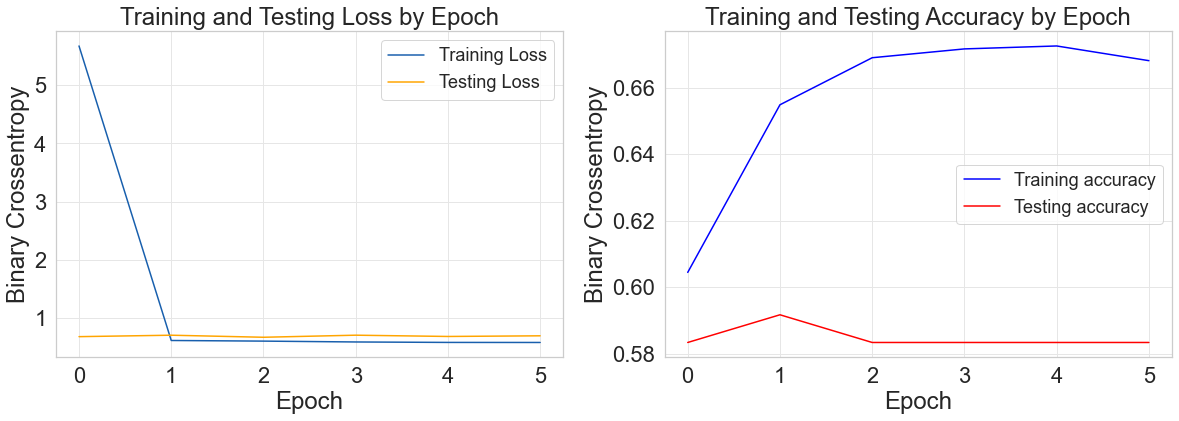

In [25]:
# coronal plane
num_epochs=30

cnn_model = build_model()
cor_men_model, hst_cmen = model_train(cnn_model, 'hst_cmen', num_epochs, coronal_mensicus, coronal_mensicus_label, coronal_mensicus_val, coronal_mensicus_label_val)

# get/plot accuracy
hst_cmen_acc=[]
hst_cmen_acc.append(np.mean(hst_cmen.history['val_accuracy']))
plot_results(hst_cmen)

Epoch 1/30
36/36 [==============================] - 58s 2s/step - loss: 7.5372 - accuracy: 0.5956 - val_loss: 0.6629 - val_accuracy: 0.5917
Epoch 2/30
36/36 [==============================] - 56s 2s/step - loss: 0.6705 - accuracy: 0.6062 - val_loss: 0.6675 - val_accuracy: 0.5833
Epoch 3/30
36/36 [==============================] - 56s 2s/step - loss: 0.6340 - accuracy: 0.6637 - val_loss: 0.6689 - val_accuracy: 0.5750
Epoch 4/30
36/36 [==============================] - 56s 2s/step - loss: 0.6214 - accuracy: 0.6832 - val_loss: 0.6695 - val_accuracy: 0.6083


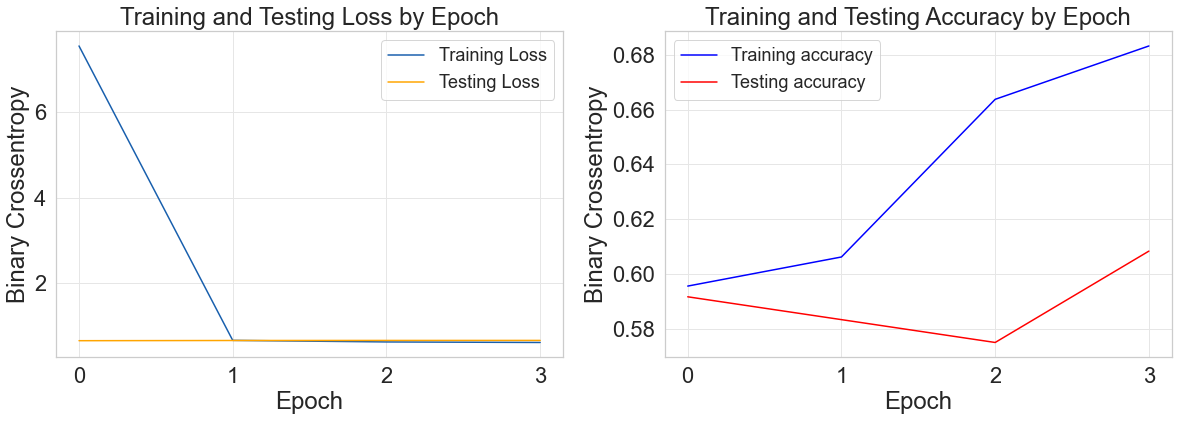

In [26]:
# axial plane
num_epochs=30

cnn_model = build_model()
axl_men_model, hst_amen = model_train(cnn_model, 'hst_amen', num_epochs, axial_mensicus, axial_mensicus_label, axial_mensicus_val, axial_mensicus_label_val)

# get/plot accuracy
hst_amen_acc=[]
hst_amen_acc.append(np.mean(hst_amen.history['val_accuracy']))
plot_results(hst_amen)

Epoch 1/30
36/36 [==============================] - 58s 2s/step - loss: 19.9298 - accuracy: 0.5726 - val_loss: 0.6673 - val_accuracy: 0.5833
Epoch 2/30
36/36 [==============================] - 62s 2s/step - loss: 0.6119 - accuracy: 0.6619 - val_loss: 0.6319 - val_accuracy: 0.6083
Epoch 3/30
36/36 [==============================] - 59s 2s/step - loss: 0.5833 - accuracy: 0.6788 - val_loss: 0.6430 - val_accuracy: 0.5917
Epoch 4/30
36/36 [==============================] - 56s 2s/step - loss: 0.5627 - accuracy: 0.7027 - val_loss: 0.6378 - val_accuracy: 0.6333
Epoch 5/30
36/36 [==============================] - 56s 2s/step - loss: 0.5438 - accuracy: 0.7000 - val_loss: 0.6318 - val_accuracy: 0.6250
Epoch 6/30
36/36 [==============================] - 55s 2s/step - loss: 0.5203 - accuracy: 0.7451 - val_loss: 0.6294 - val_accuracy: 0.6583
Epoch 7/30
36/36 [==============================] - 56s 2s/step - loss: 0.4982 - accuracy: 0.7655 - val_loss: 0.6186 - val_accuracy: 0.6750
Epoch 8/30
36/36 [=

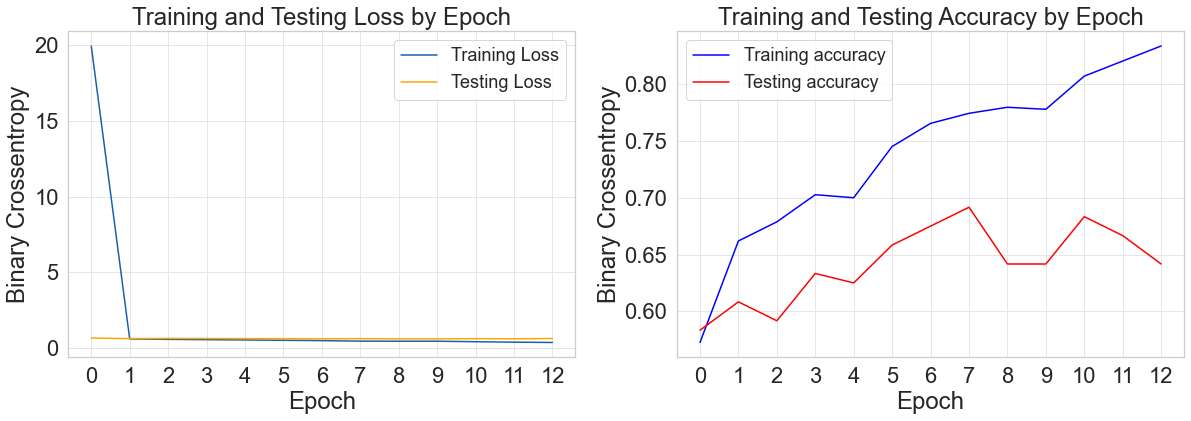

In [27]:
# sagittal plane
num_epochs=30

cnn_model = build_model()
sag_men_model, hst_smen = model_train(cnn_model, 'hst_smen', num_epochs, sagittal_mensicus, sagittal_mensicus_label, sagittal_mensicus_val, sagittal_mensicus_label_val)

# get/plot accuracy
hst_smen_acc=[]
hst_smen_acc.append(np.mean(hst_smen.history['val_accuracy']))
plot_results(hst_smen)

**calculate average accuracy**

In [28]:
[hst_cmen_acc, hst_amen_acc, hst_smen_acc]

[[0.5847222010294596], [0.5895833224058151], [0.6416666645270127]]

## Evaluate results

In [29]:
cmen_scores = cor_men_model.evaluate(coronal_mensicus_val, np.array(coronal_mensicus_label_val), verbose=0)
print('Test loss:', cmen_scores[0]) 
print('Test accuracy:', cmen_scores[1])

Test loss: 0.6997183561325073
Test accuracy: 0.5833333134651184


In [30]:
amen_scores = axl_men_model.evaluate(axial_mensicus_val, np.array(axial_mensicus_label_val), verbose=0)
print('Test loss:', amen_scores[0]) 
print('Test accuracy:', amen_scores[1])

Test loss: 0.6694735884666443
Test accuracy: 0.6083333492279053


In [31]:
smen_scores = sag_men_model.evaluate(sagittal_mensicus_val, np.array(sagittal_mensicus_label_val), verbose=0)
print('Test loss:', smen_scores[0]) 
print('Test accuracy:', smen_scores[1])

Test loss: 0.6406071782112122
Test accuracy: 0.6416666507720947


**Evaluate predictions**

In [32]:
cor_pred = cor_men_model.predict(coronal_mensicus_val) 
axl_pred = axl_men_model.predict(axial_mensicus_val) 
sag_pred = sag_men_model.predict(sagittal_mensicus_val) 


In [33]:
pred = pd.DataFrame(np.column_stack([cor_pred,axl_pred,sag_pred]),columns=['cor_pred', 'axl_pred', 'sag_pred'])
pred['mean'] = pred.mean(axis=1)

In [34]:
# since model output is [0,1] using sigmoid activation function
# pred is the probability
# take average probability from all 3 planes
pred['mean']

0      0.168691
1      0.182779
2      0.200930
3      0.145470
4      0.469323
         ...   
115    0.308367
116    0.369919
117    0.276794
118    0.365275
119    0.178955
Name: mean, Length: 120, dtype: float32

In [35]:
# if prob<0.5, it is 0.
pred['predict'] = pred['mean'].map(lambda x: 0 if x<0.5 else 1)

In [36]:
pred['predict'].value_counts()

0    102
1     18
Name: predict, dtype: int64

In [37]:
pred['true'] = coronal_mensicus_label_val

In [38]:
pred[pred['true'] != pred['predict']].shape

(46, 6)

In [39]:
pred[pred['true'] != pred['predict']]

,cor_pred,axl_pred,sag_pred,mean,predict,true
5,0.492036,0.649747,0.575552,0.572445,1,0
42,0.310065,0.368962,0.076817,0.251948,0,1
43,0.292898,0.339959,0.528897,0.387251,0,1
44,0.343943,0.392569,0.447636,0.394716,0,1
46,0.212257,0.347506,0.557880,0.372548,0,1
47,0.433285,0.377407,0.819018,0.543237,1,0
53,0.491411,0.750903,0.390348,0.544221,1,0
56,0.278539,0.377082,0.837904,0.497842,0,1
57,0.472573,0.483126,0.711082,0.555594,1,0
58,0.256544,0.308784,0.678647,0.414658,0,1


**export results to csv**

In [40]:
pred.to_csv('../data/pred_men_results.csv')